In [33]:
# Cell 1: Installation
# Run this cell once to install necessary libraries
!pip install opencv-python pillow numpy pandas scikit-learn joblib pywhatkit ipywidgets

Running Quick Test...
Created dummy test image.


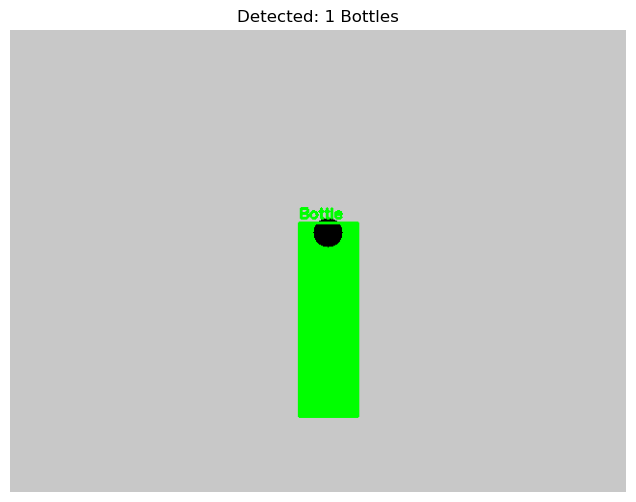

In [34]:
# Cell 2: Quick Test (Manual Simulation)
# Purpose: Verify detection logic on a static image before running live.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
def quick_test_detection(image_path=None):
    """
    Simulates the detection pipeline on a single image.
    If image_path is None, creates a dummy image for demonstration.
    """
    if image_path:
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Error: Could not load {image_path}")
            return
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        # Create a dummy image with a green rectangle and black circle
        frame = np.ones((480, 640, 3), dtype=np.uint8) * 200
        # Draw "bottle" (Green)
        cv2.rectangle(frame, (300, 200), (360, 400), (0, 255, 0), -1)
        # Draw "cap" (Black)
        cv2.circle(frame, (330, 210), 15, (0, 0, 0), -1)
        print("Created dummy test image.")
    # --- Detection Logic (Simplified for Test) ---
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    # Neon Green approx range
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bottle_count = 0
    
    debug_frame = frame.copy()
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500: # Min area
            x, y, w, h = cv2.boundingRect(cnt)
            
            # Cap Detection: Look in the top 30% of the bounding box
            roi_h = int(h * 0.3)
            roi = frame[y:y+roi_h, x:x+w]
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
            
            # Check for dark regions (caps)
            # Method: Thresholding + Contour
            _, cap_thresh = cv2.threshold(gray_roi, 60, 255, cv2.THRESH_BINARY_INV)
            cap_contours, _ = cv2.findContours(cap_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            has_cap = False
            for c_cap in cap_contours:
                if cv2.contourArea(c_cap) > 20: # Min cap area
                    has_cap = True
                    break
            
            if has_cap:
                bottle_count += 1
                cv2.rectangle(debug_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(debug_frame, "Bottle", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                cv2.rectangle(debug_frame, (x, y), (x+w, y+h), (255, 0, 0), 1) # Red for no cap
    plt.figure(figsize=(10, 6))
    plt.imshow(debug_frame)
    plt.title(f"Detected: {bottle_count} Bottles")
    plt.axis('off')
    plt.show()
# Run the test
print("Running Quick Test...")
quick_test_detection() 

In [35]:
# Cell 3: Setup and UI Widgets
# Purpose: Import libraries, setup folders, and create the data collection UI.
import cv2
import numpy as np
import os
import pandas as pd
import datetime
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import threading
import time
# 1. Setup Directories and Files
if not os.path.exists('md_images'):
    os.makedirs('md_images')
CSV_FILE = 'md_counts.csv'
if not os.path.exists(CSV_FILE):
    df = pd.DataFrame(columns=['filename', 'count', 'timestamp'])
    df.to_csv(CSV_FILE, index=False)
# 2. Global Variables for UI
stop_camera = False
save_trigger = False
current_frame_bgr = None
# 3. UI Widgets
image_widget = widgets.Image(format='jpeg', width=640, height=480)
count_input = widgets.IntText(value=5, description='True Count:', disabled=False)
save_button = widgets.Button(description="Save Training Data", button_style='success')
stop_button = widgets.Button(description="Stop Camera", button_style='danger')
status_label = widgets.Label(value="Status: Ready")
# 4. Event Handlers
def on_save_clicked(b):
    global save_trigger
    save_trigger = True
    status_label.value = "Status: Saving..."
def on_stop_clicked(b):
    global stop_camera
    stop_camera = True
    status_label.value = "Status: Stopping..."
save_button.on_click(on_save_clicked)
stop_button.on_click(on_stop_clicked)
# Layout
ui_box = widgets.VBox([
    image_widget,
    widgets.HBox([count_input, save_button, stop_button]),
    status_label
])
print("Setup Complete. UI Widgets created.")

Setup Complete. UI Widgets created.


In [36]:
# Cell 4: Camera Capture & Data Collection
# Purpose: Live webcam feed with CV detection. Collects training data.
# TUNING PARAMETERS
HSV_LOWER = np.array([35, 100, 100]) # Lower bound for Neon Green
HSV_UPPER = np.array([85, 255, 255]) # Upper bound for Neon Green
MIN_AREA = 1000                      # Min area for bottle contour
CAP_ROI_HEIGHT_RATIO = 0.35          # Top 35% of bottle to look for cap
CAP_INTENSITY_THRESH = 80            # Max intensity to consider "black"
CAP_MIN_AREA = 50                    # Min area for a cap contour
def run_data_collection_camera():
    global stop_camera, save_trigger, current_frame_bgr
    stop_camera = False
    
    # Open camera in the thread to avoid blocking
    def camera_loop():
        global stop_camera, save_trigger, current_frame_bgr
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Could not open webcam.")
            return
        print("Camera Thread Started.")
        
        while not stop_camera:
            ret, frame = cap.read()
            if not ret:
                break
                
            current_frame_bgr = frame.copy()
            
            # --- CV PIPELINE ---
            # A) Color Segmentation (Neon Green)
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
            
            # Morphological ops to clean up noise
            kernel = np.ones((5,5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            detected_bottles = 0
            
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area > MIN_AREA:
                    x, y, w, h = cv2.boundingRect(cnt)
                    
                    # B) Black Cap Detection
                    # Look only in the top portion of the bounding box
                    roi_h = int(h * CAP_ROI_HEIGHT_RATIO)
                    roi = frame[y:y+roi_h, x:x+w]
                    
                    if roi.size > 0:
                        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                        
                        # Threshold to find dark objects (caps)
                        _, cap_thresh = cv2.threshold(gray_roi, CAP_INTENSITY_THRESH, 255, cv2.THRESH_BINARY_INV)
                        
                        # Check for cap contours
                        cap_contours, _ = cv2.findContours(cap_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        
                        has_cap = False
                        for c_cap in cap_contours:
                            if cv2.contourArea(c_cap) > CAP_MIN_AREA:
                                has_cap = True
                                break
                        
                        if has_cap:
                            detected_bottles += 1
                            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                            cv2.putText(frame, "Dew", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                            cv2.rectangle(frame, (x, y), (x+w, y+roi_h), (0, 0, 255), 1)
                        else:
                            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1)
            # Overlay Info
            cv2.putText(frame, f"CV Count: {detected_bottles}", (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # --- SAVE DATA ---
            if save_trigger:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"dew_{timestamp}.jpg"
                filepath = os.path.join('md_images', filename)
                
                # Save the ORIGINAL frame (without boxes) for training
                cv2.imwrite(filepath, current_frame_bgr)
                
                # Append to CSV
                true_count = count_input.value
                new_row = pd.DataFrame({'filename': [filename], 'count': [true_count], 'timestamp': [timestamp]})
                new_row.to_csv(CSV_FILE, mode='a', header=False, index=False)
                
                # Update status safely
                status_label.value = f"Saved {filename} | Count: {true_count}"
                save_trigger = False
                time.sleep(0.2) 
            # Update Widget
            _, encoded_image = cv2.imencode('.jpg', frame)
            image_widget.value = encoded_image.tobytes()
            
            # Sleep to limit FPS and let other threads run
            time.sleep(0.05)
            
        cap.release()
        status_label.value = "Camera Stopped"
    print("Starting Camera in Background Thread... Click 'Stop Camera' to finish.")
    display(ui_box)
    threading.Thread(target=camera_loop).start()
# Run the collection loop
run_data_collection_camera()

Starting Camera in Background Thread... Click 'Stop Camera' to finish.


Camera Thread Started.


In [37]:
# Cell 5: Quick Data Inspection
# Purpose: Check how many images we have collected.
import pandas as pd
import os
print("--- Inspecting Data ---")
if os.path.exists('md_counts.csv'):
    try:
        df = pd.read_csv('md_counts.csv')
        print(f"Total Records in CSV: {len(df)}")
        if len(df) > 0:
            print(f"Total Images in Folder: {len(os.listdir('md_images'))}")
            print("\nFirst 5 rows:")
            print(df.head())
        else:
            print("CSV is empty. Please collect data in Cell 4.")
    except Exception as e:
        print(f"Error reading CSV: {e}")
else:
    print("md_counts.csv not found. Did you run Cell 3?")

--- Inspecting Data ---
Total Records in CSV: 493
Total Images in Folder: 177

First 5 rows:
                  filename  count        timestamp
0  dew_20251215_172852.jpg      5  20251215_172852
1  dew_20251215_172853.jpg      5  20251215_172853
2  dew_20251215_172854.jpg      5  20251215_172854
3  dew_20251215_172856.jpg      5  20251215_172856
4  dew_20251215_172856.jpg      5  20251215_172856


In [16]:
# Cell 6: Robust Training Cell
# Purpose: Train a RandomForestRegressor to predict bottle count from images.
import pandas as pd
import numpy as np
import os
import cv2
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
IMG_SIZE = 64 # Resize images to 64x64 for speed
def train_model():
    print("--- Starting Model Training ---")
    print("Loading data from md_counts.csv...")
    if not os.path.exists('md_counts.csv'):
        print("Error: md_counts.csv not found. Run data collection first.")
        return
    try:
        df = pd.read_csv('md_counts.csv')
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return
        
    if len(df) == 0:
        print("Error: CSV is empty. You need to collect images in Cell 4 first!")
        return
    
    X = []
    y = []
    valid_count = 0
    
    print(f"Found {len(df)} records. Processing images...")
    
    for index, row in df.iterrows():
        img_path = os.path.join('md_images', row['filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                # Preprocess: Resize and Flatten
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                flat_img = img.flatten() / 255.0 # Normalize
                
                X.append(flat_img)
                y.append(row['count'])
                valid_count += 1
            else:
                print(f"Warning: Could not read image {img_path}")
        else:
            print(f"Warning: Image not found {img_path}")
    
    print(f"Successfully loaded {valid_count} valid images.")
    
    if valid_count < 8:
        print(f"Error: Too few samples ({valid_count}). Please collect at least 8-10 images in Cell 4.")
        return
    X = np.array(X)
    y = np.array(y)
    
    print(f"Training on {len(X)} samples...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Model
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rounded_preds = np.round(preds)
    acc = accuracy_score(y_test, rounded_preds)
    
    print(f"Model Trained! MAE: {mae:.2f}, Accuracy (rounded): {acc*100:.1f}%")
    
    # Save Model
    joblib.dump(model, 'md_count_model.pkl')
    print("Model saved to md_count_model.pkl")
train_model()

--- Starting Model Training ---
Loading data from md_counts.csv...
Found 431 records. Processing images...
Successfully loaded 431 valid images.
Training on 431 samples...
Model Trained! MAE: 0.00, Accuracy (rounded): 100.0%
Model saved to md_count_model.pkl


In [38]:
# Cell 7: Live Inference & Alerting
# Purpose: Live monitoring with Lock-and-Wait alert logic.
import cv2
import numpy as np
import joblib
import pywhatkit
import threading
import time
import ipywidgets as widgets
from IPython.display import display

# --- CONFIGURATION ---
PHONE_NUMBER = "+919846516116"
LOW_STOCK_THRESHOLD = 3
COUNTDOWN_SECONDS = 5
WHATSAPP_WAIT_TIME = 20        # Increased to 30s as requested to ensure WhatsApp Web loads fully

# --- STATE VARIABLES ---
stop_inference = False
alert_sent = False
locked_state = False
locked_count = 0
lock_start_time = 0

# --- LOAD MODEL ---
try:
    model = joblib.load('md_count_model.pkl')
    print("Model loaded successfully.")
except:
    print("WARNING: Model not found. Running in CV-only mode.")
    model = None

# --- WHATSAPP WORKER ---
def send_whatsapp_alert():
    print("\n[Background] Triggering WhatsApp Alert...")
    try:
        pywhatkit.sendwhatmsg_instantly(
            PHONE_NUMBER, 
            "ALERT: Mountain Dew Stock is LOW (Below 3)! Please refill. - Tuck Shop", 
            wait_time=WHATSAPP_WAIT_TIME,
            tab_close=True
        )
        print(f"[Background] Alert Sent.")
    except Exception as e:
        print(f"[Background] Failed to send alert: {e}")

# --- UI WIDGETS ---
inf_image_widget = widgets.Image(format='jpeg', width=640, height=480)
inf_stop_button = widgets.Button(description="Stop Monitoring", button_style='danger')
inf_test_alert_btn = widgets.Button(description="Test WhatsApp", button_style='warning')
inf_status_label = widgets.Label(value="Status: Starting...")

# Tuning Sliders
thresh_slider = widgets.IntSlider(value=80, min=0, max=255, description='Cap Dark Thresh:')
area_slider = widgets.IntSlider(value=1000, min=100, max=5000, description='Min Bottle Area:')
debug_checkbox = widgets.Checkbox(value=False, description='Show Debug Boxes')

def on_inf_stop(b):
    global stop_inference
    stop_inference = True

def on_test_alert(b):
    threading.Thread(target=send_whatsapp_alert).start()

inf_stop_button.on_click(on_inf_stop)
inf_test_alert_btn.on_click(on_test_alert)

controls = widgets.VBox([
    widgets.HBox([inf_stop_button, inf_test_alert_btn]),
    widgets.HBox([thresh_slider, area_slider, debug_checkbox]),
    inf_status_label
])

display(widgets.VBox([inf_image_widget, controls]))

# --- INFERENCE LOOP ---
def run_inference():
    global stop_inference, alert_sent, locked_state, locked_count, lock_start_time
    stop_inference = False
    alert_sent = False
    locked_state = False
    
    def inference_thread():
        global stop_inference, alert_sent, locked_state, locked_count, lock_start_time
        
        print("Attempting to open camera...")
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            inf_status_label.value = "Error: Camera Busy"
            return
            
        inf_status_label.value = "Status: Running"
        
        while not stop_inference:
            ret, frame = cap.read()
            if not ret: break
            
            # Draw UI Overlay placeholders
            status_text = "Stock OK"
            status_color = (0, 255, 0)
            final_count = 0
            
            if locked_state:
                # --- LOCKED STATE (Countdown) ---
                # Don't run CV/ML. Just show the locked count.
                final_count = locked_count
                
                elapsed = time.time() - lock_start_time
                remaining = COUNTDOWN_SECONDS - elapsed
                
                if remaining > 0:
                    status_text = f"LOCKED! Sending in {remaining:.1f}s..."
                    status_color = (0, 165, 255) # Orange
                else:
                    # Time's up! Send Alert.
                    status_text = "SENDING ALERT & STOPPING..."
                    status_color = (0, 0, 255) # Red
                    
                    # 1. Start the alert thread
                    threading.Thread(target=send_whatsapp_alert).start()
                    
                    # 2. Set flag to STOP monitoring immediately
                    stop_inference = True
                    
                    # 3. Update status (though loop breaks immediately after)
                    alert_sent = True
                    locked_state = False
                    
                    # 4. Break loop explicitly to ensure no further processing
                    break
            
            else:
                # --- MONITORING STATE ---
                # Run CV/ML logic
                
                # Get sliders
                CAP_INTENSITY_THRESH = thresh_slider.value
                MIN_AREA = area_slider.value
                SHOW_DEBUG = debug_checkbox.value
                
                # 1. CV
                hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
                # NOTE: HSV_LOWER and HSV_UPPER must be defined in previous cells
                mask = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
                kernel = np.ones((5,5), np.uint8)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                cv_count = 0
                for cnt in contours:
                    if cv2.contourArea(cnt) > MIN_AREA:
                        x, y, w, h = cv2.boundingRect(cnt)
                        if SHOW_DEBUG: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1)
                        
                        roi_h = int(h * CAP_ROI_HEIGHT_RATIO)
                        roi = frame[y:y+roi_h, x:x+w]
                        if roi.size > 0:
                            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                            _, cap_thresh = cv2.threshold(gray_roi, CAP_INTENSITY_THRESH, 255, cv2.THRESH_BINARY_INV)
                            cap_contours, _ = cv2.findContours(cap_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                            if any(cv2.contourArea(c) > CAP_MIN_AREA for c in cap_contours):
                                cv_count += 1
                                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                                cv2.putText(frame, "Dew", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                # 2. ML
                ml_count = 0
                if model:
                    try:
                        img_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                        flat_vec = img_rgb.flatten() / 255.0
                        ml_count = model.predict([flat_vec])[0]
                    except: pass
                
                # 3. Ensemble
                if model:
                    final_count = round(0.7 * ml_count + 0.3 * cv_count)
                else:
                    final_count = cv_count
                
                # 4. Check Trigger
                if final_count < LOW_STOCK_THRESHOLD:
                    if not alert_sent:
                        # TRIGGER LOCK
                        locked_state = True
                        locked_count = final_count
                        lock_start_time = time.time()
                    else:
                        status_text = "Stock Low (Alert Sent)"
                        status_color = (0, 0, 255)
                else:
                    # Reset alert flag if stock recovers
                    if alert_sent:
                        alert_sent = False
                        status_text = "Stock Recovered"
            
            # Display
            cv2.putText(frame, f"Final: {int(final_count)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, status_color, 3)
            cv2.putText(frame, status_text, (10, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, status_color, 2)
            _, encoded_image = cv2.imencode('.jpg', frame)
            inf_image_widget.value = encoded_image.tobytes()
            time.sleep(0.05)
        
        cap.release()
        inf_status_label.value = "Monitoring Stopped (Alert Triggered)"
    
    threading.Thread(target=inference_thread).start()

print("Starting Inference Thread...")
run_inference()


Model loaded successfully.


Starting Inference Thread...
Attempting to open camera...
